# Faces recognition example using eigenfaces and SVMs

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import os
import cv2
import numpy as np
from keras.utils import np_utils

%matplotlib inline

Using TensorFlow backend.


In [3]:
DatasetPath = []
for i in os.listdir("data/yalefaces"):
    DatasetPath.append(os.path.join("data/yalefaces", i))

In [4]:
imageLabels = []
for i in DatasetPath:   
    labelRead = int(os.path.split(i)[1].split(".")[0].replace("subject", "")) - 1
    imageLabels.append(labelRead)

In [5]:
faceDetectClassifier = cv2.CascadeClassifier("models/haarcascade_frontalface_default.xml")

In [6]:
imageDataFin = []
for file_name in DatasetPath:
    gray = cv2.imread(file_name,0)

    faces = faceDetectClassifier.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    )
    faces = faceDetectClassifier.detectMultiScale(gray, 1.2, 5)

#     print("Found {0} faces!".format(len(faces)))

    # Draw a rectangle around the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(gray, (x, y), (x+w, y+h), (0, 255, 0), 2)
        thing = gray[y: y + w, x: x + h]

    thing = cv2.resize(thing,(150,150))
    imageDataFin.append(thing)

In [7]:
h = w = 150

In [8]:
X_train, X_test, y_train, y_test = train_test_split(np.array(imageDataFin),np.array(imageLabels), train_size=0.9, random_state = 20)

In [9]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train) 
y_test = np.array(y_test) 

In [10]:
nb_classes = 15
nb_train = X_train.shape[0]
nb_test = X_test.shape[0]

In [11]:
X_train = X_train.reshape(nb_train, 150*150)
X_test = X_test.reshape(nb_test, 150*150)

In [12]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

In [13]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
dataset): unsupervised feature extraction / dimensionality reduction


In [14]:
n_components = 100

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, nb_train))

pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)

print("done")

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done")

Extracting the top 100 eigenfaces from 149 faces
done
Projecting the input data on the eigenfaces orthonormal basis
done


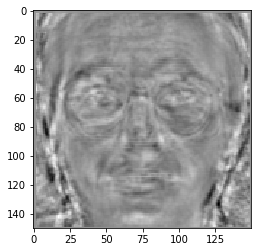

In [15]:
plt.imshow(eigenfaces[np.random.randint(100)].reshape((h,w)), cmap='gray')

Train a SVM classification model


In [16]:
print("Fitting the classifier to the training set")
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done")
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


Quantitative evaluation of the model quality on the test set


In [17]:
print("Predicting people's names on the test set")
y_pred = clf.predict(X_test_pca)
print("done")

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred, labels=range(nb_classes)))

Predicting people's names on the test set
done
             precision    recall  f1-score   support

          2       0.00      0.00      0.00         0
          4       0.00      0.00      0.00         0
          5       1.00      1.00      1.00         2
          6       1.00      1.00      1.00         1
          8       1.00      1.00      1.00         2
          9       1.00      1.00      1.00         2
         10       1.00      1.00      1.00         2
         11       1.00      1.00      1.00         1
         12       1.00      1.00      1.00         2
         13       1.00      0.67      0.80         3
         14       1.00      0.50      0.67         2

avg / total       1.00      0.88      0.93        17

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [18]:
accuracy = []
for idx, pred in enumerate(y_pred):
    result = 1 if pred == y_test[idx] else 0
    accuracy.append(result)

In [19]:
print("Prediction accuracy on test set {} for {} examples".format(float(np.sum(accuracy)/len(accuracy)),len(accuracy)))

Prediction accuracy on test set 0.8823529411764706 for 17 examples


In [20]:
X_train_pca.shape

(149, 100)